In [1]:
from datasets import wine_white_dataset
import pandas as pd
wine_white = wine_white_dataset()
wine_white.dropna(how='all', inplace=True)

Under the assumption that we do not have many features and many of these few features have low impact on quality, it is assumed to be more effective when we sort out good features rather than reducing many features into a smaller amount.

In some cases, applying both methods of data reduction may make sense. It would make more sense to apply both methods when we have a large amount of base features and still a large amount of features after selecting good ones. But if we only have just a few good features, we should not reduce them further.

# Feature selection

## VIF

When a model is trained with colinear features, the coefficients (weights) tend to depend on each other which reduces explanability of the model. Find features that have high colinearity. 

Variance Inflation Factor, measures how much the variance of an estimated regression coefficient is increased because of collinearity

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
x = wine_white.dropna().drop('quality', axis=1).drop('ID', axis=1)
vif_factors = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)
vif_factors = round(vif_factors, 2)
display(vif_factors)

fixed acidity                 2.70
volatile acidity              1.14
citric acid                   1.17
residual sugar               12.64
chlorides                     1.24
flavanoids              3062203.80
free sulfur dioxide           1.79
total sulfur dioxide          2.24
density                      28.22
pH                            2.20
magnesium                     1.00
sulphates                     1.14
alcohol                      10.17
lightness                     3.77
dtype: float64

- => alcohol and lightness seem to have high colinearity
- => residual sugar and density seem to have high colinearity

In [3]:
wine_white['alcohol'].corr(wine_white['lightness'])

-0.8563701904472735

In [7]:
wine_white['residual sugar'].corr(wine_white['density'])

0.8389412171940377

alcohol and lightness have high negative correlation

In [8]:
x = wine_white.dropna().drop('quality', axis=1).drop('lightness',axis=1).drop('density', axis=1).drop('ID', axis=1)
vif_factors = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)
vif_factors = round(vif_factors, 2)

display(vif_factors)

fixed acidity              1.36
volatile acidity           1.13
citric acid                1.16
residual sugar             1.44
chlorides                  1.20
flavanoids              1047.80
free sulfur dioxide        1.75
total sulfur dioxide       2.15
pH                         1.33
magnesium                  1.00
sulphates                  1.06
alcohol                    1.65
dtype: float64

when removing lightness and density as a feature, the colinearity disappears

## Information Gain

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import numpy as np

wine_white_nan = wine_white.dropna()
x = wine_white_nan.drop('ID', axis=1).drop('quality', axis=1)
y = wine_white_nan['quality']

def get_kbest_sorted(selector,x,y):
    flt = SelectKBest(selector).fit(x,y)
    scores = flt.scores_
    best_features = pd.DataFrame(scores,index=x.columns, columns=['score'])
    for i in range(1,25):
        np.random.seed(i)
        flt = SelectKBest(selector).fit(x,y)
        scores = flt.scores_
        df = pd.DataFrame(scores,index=x.columns, columns=['score'])
        best_features = df + best_features
    best_features = best_features / i
    best_features = best_features.sort_values(by=['score'], ascending=False)
    return best_features

#filtering using Mutual Information = Information Gain
kbest_mutual_info_regression = get_kbest_sorted(mutual_info_regression, x, y)

display(kbest_mutual_info_regression)

,score
density,0.186502
alcohol,0.163051
residual sugar,0.095898
total sulfur dioxide,0.095637
lightness,0.094339
chlorides,0.068150
free sulfur dioxide,0.057722
citric acid,0.054419
volatile acidity,0.049337
pH,0.035531


The mutual_info_regression selector is dependent on random state, which is different every execution. Because of this condition we calculate a mean over 25 iterations to have a more secure output

we could delete following features:
- chlorides
- density
- free sulfur dioxide
- residual sugar
- pH
- magnesium
- flavanoids

We could also merge them into one feature

## Correlation

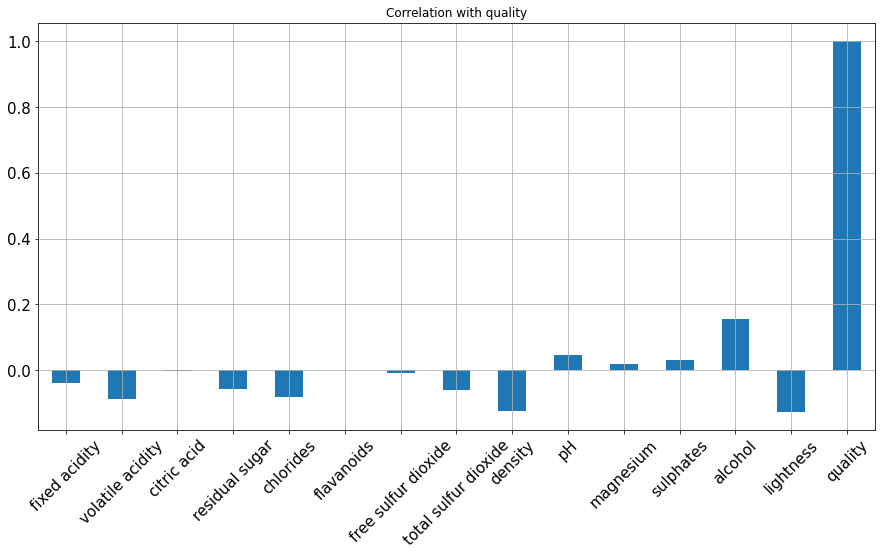

In [10]:
wine_white.drop('ID', axis=1).corrwith(wine_white['quality']).plot.bar(
        figsize = (15, 7.5), title = "Correlation with quality", fontsize = 15,
        rot = 45, grid = True)

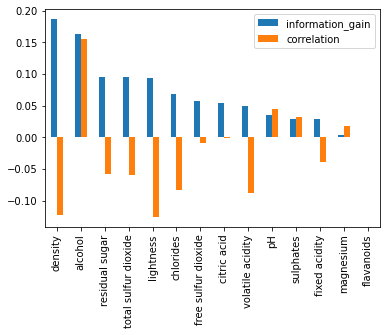

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build new DataFrame for information gain and correlation side by side
corr = wine_white.drop('ID', axis=1).corrwith(wine_white['quality'])
features = kbest_mutual_info_regression.index
values = []
for feature in features:
    # access correct values by index
    values.append([kbest_mutual_info_regression.loc[feature,'score'], corr[feature]])
df = pd.DataFrame(values, columns=['information_gain', 'correlation'], index=features)
df.plot.bar()

plt.show()

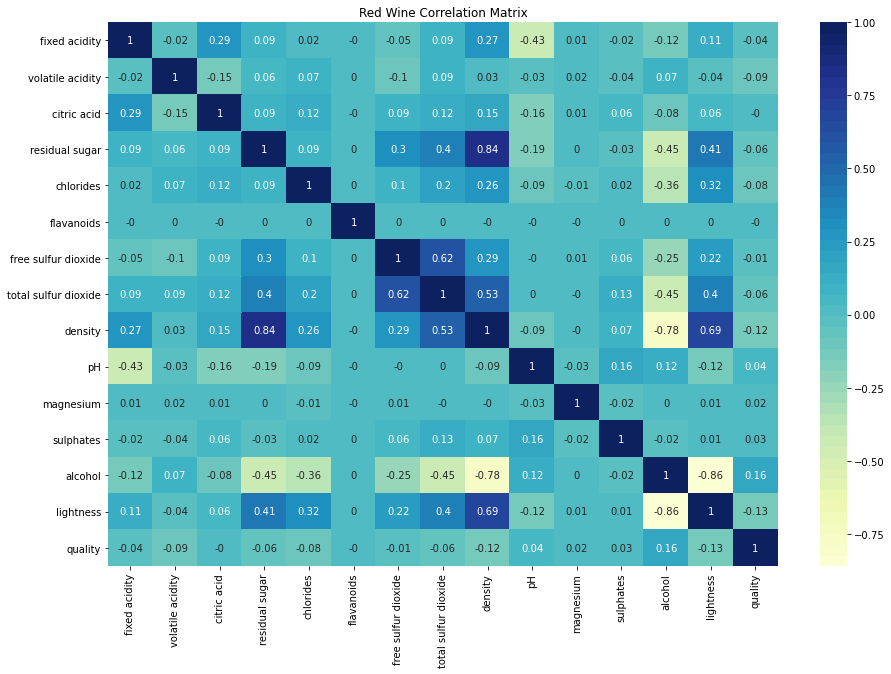

In [12]:
import seaborn as sns
correlations = round(wine_white.drop('ID', axis=1).corr(), 2)
plt.figure(figsize = (15, 10))
ax = sns.heatmap(correlations, annot=True, cmap = sns.color_palette("YlGnBu", 50))
ax.axes.set_title("White Wine Correlation Matrix")
plt.show()

In [ ]:
Flavanoids have a constant value across all data. This leads to a variance of zero and hence an undefined correlation with other features, since division by zero is not possible.

Highest correlating features:
- fixed acidity / citric acid 0.67
- free sulfur dioxide / total sulfur dioxide 0.67
- lightness / density 0.48
- density / fixed acidity 0.34

most negatively correlating features:
- alcohol / lightness -0.95
- volatile acidity / citric acd -0.55
- alcohol / density -0.52

## Summary
- use alcohol as the major feature, lightness and density have high correlation with it, so it's even better to remove both
- remove lightness because it is highly colinear with alcohol
- use sulphates as a feature
- use citric acid as a feature, it also correlates with fixed acidity. This is why fixed acidity should be removed.
- volatice acidity and citric acid have relatively high correlation. remove volatile acidity or keep both.
- use chlorides as a feature
- remove all other features

# Feature reduction

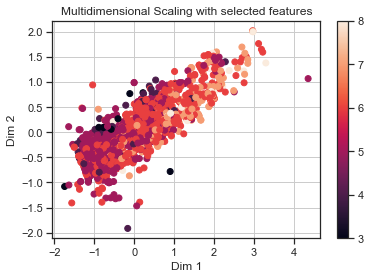

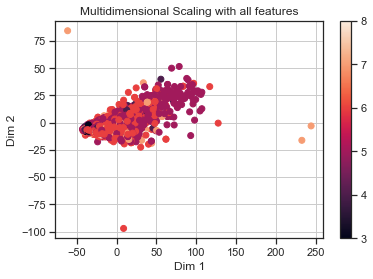

In [27]:
#Multidimensional scaling
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
selected_features = ['alcohol', 'sulphates', 'citric acid', 'chlorides', 'volatile acidity']
def visualize_MDS(data_transformed, label_transformed, title):
    #Create a matplot scatter plot visualizing the transformed data, indicating the target through color
    plt.scatter(data_transformed[:,0],data_transformed[:,1],c=label_transformed)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid()
    plt.colorbar()
    plt.show()

#Load the diabetes sklearn toy dataset
x_selected = wine_white.dropna()[selected_features]
x_all = wine_white.dropna().drop('ID', axis=1).drop('quality',axis=1)
y = wine_white.dropna()['quality']

#Perform multdimensional scaling using the MDS class and 2 dimensions on the first 200 examples 
embedding_selected = MDS(n_components=2)
embedding_all = MDS(n_components=2)
data_trans_selected = embedding_all.fit_transform(x_selected)
data_trans_all = embedding_all.fit_transform(x_all)
label_trans= y

#Call visualization function
visualize_MDS(data_trans_selected, label_trans, "Multidimensional Scaling with selected features")
visualize_MDS(data_trans_all, label_trans, "Multidimensional Scaling with all features")

- Our feature selection seems to have an impact on the MDS, because there is a more strict border between good quality red wine and bad quality red wine
- If a linear regression function is drawn inside the dataset, it is indicated that there is a linear dependency of quality.
- Higher valued dimensions seem to result in higher quality.